Notebook to plot clustered info on pclass.

Uses pickle files "pclass_itest_read_XXhrs.pkl" generated by precip_class_ddt.ipynb.

James Ruppert  
jruppert@ou.edu  
10/7/24

### Main settings

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors
from precip_class import *
from read_functions import *
import seaborn as sns
from scipy.ndimage import label, sum as ndi_sum
import pickle
import pandas as pd
from scipy import stats
import cmocean

In [9]:
# t1_test=6 # max of 48
t1_test=48 # max of 48

storm = 'haiyan'
# storm = 'maria'

# Write out pickle file?
do_write=True
do_write=False

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"+storm+'/'
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
# main_pickle = "/Users/jamesruppert/code/pickle_out/tc_postproc/"+storm+'/'

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
# pclass_names=["Non-cloud", "DeepC", "Congestus", "Shallow", "Stratiform", "Anvil"]
pclass_names=["Non-cloud", "Deep", "Congestus", "Shallow", "Stratiform", "Anvil", "MCS"]
npclass=len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 1

In [7]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

### Main read loop

In [10]:
nt=t1_test

# Arrays to save variables
dims = (ntest, nmem, npclass, nt)
number = np.full(dims, np.nan)
mean_size = np.full(dims, np.nan)

for itest in range(ntest):

    test_str=tests_str[itest]
    test_read=tests[itest]
    # print('Running test: ',test_str)

    # Loop over ensemble members
    for imemb in range(nmem):

        pickle_read_pclass = main_pickle+memb_all[imemb]+'/pclass_'+test_read+'_48hrs.pkl'
        pickle_cluster = main_pickle+memb_all[imemb]+'/pclass_cluster_'+test_read+'_'+str(t1_test)+'hrs.pkl'

        if do_write:

            # PCLASS index
            with open(pickle_read_pclass, 'rb') as file:
                pclass, ipclass_area = pickle.load(file)

            for it in range(nt):
                for kpclass in range(1,npclass):
                    if kpclass < 6:
                        labeled_matrix, num_features = label(pclass[it,...] == kpclass)
                    else:
                        labeled_matrix, num_features = label(np.bitwise_or((pclass[it,...] == 1), (pclass[it,...] >= 4)))
                    cluster_sizes = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
                    number[itest, imemb, kpclass, it] = num_features
                    mean_size[itest, imemb, kpclass, it] = np.mean(cluster_sizes) # number of grid cells

            # with open(pickle_cluster, 'wb') as file:
            #     pickle.dump([number[itest,imemb,...], mean_size[itest,imemb,...]], file)

        else:

            with open(pickle_cluster, 'rb') as file:
                inumber, isize = pickle.load(file)
            number[itest,imemb,...]    = inumber
            mean_size[itest,imemb,...] = isize

### Plotting

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
sns.set_theme(style="ticks", font_scale=1.2, rc={'xtick.bottom': True, 'ytick.left': True,
                                                 "axes.spines.right": False, "axes.spines.top": False,})

#### Map of pclass and test of clustering

In [12]:
# Read functions
def get_pclass(wrffile):

    def var_read(infile, varname):
        ncfile = Dataset(infile)
        var = ncfile.variables[varname][...]
        ncfile.close()
        return np.squeeze(var)

    def qvar_read(infile, dp):
        # Read in and vertically integrate mixing ratios
        q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
        g = 9.81 # m/s^2
        nvar = len(q_list)
        q_var = []
        for ivar in range(nvar):
            ivar = var_read(infile,q_list[ivar]) # kg/kg
            q_var.append(ivar)
        q_var = np.stack(q_var, axis=0)
        q_int = np.sum(q_var*dp, axis=1)/(-g)
        return q_int

    # Read in hydrostatic pressure to get dp for integral
    p_hyd = var_read(wrffile,'P_HYD') # Pa
    p_hyd = np.ma.masked_where((p_hyd < 100e2), p_hyd, copy=False) # Mask out levels above 100 hPa
    dp = np.gradient(p_hyd, axis=0, edge_order=1) # [Pa] Uses second order centered differencing

    # Run new classification
    q_int = qvar_read(wrffile, dp)
    c_type = precip_class(q_int)

    return np.squeeze(c_type)

In [13]:
# Plot functions

xlim = (400,2200)
ylim = (200,1500)

def pclass_map(c_type, xdim, ydim):
    bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
    nlevs = len(bounds) - 1
    cmap = plt.get_cmap('Accent_r', nlevs)
    fig = plt.figure(figsize=(12,10))
    fig.set_facecolor('white')
    ax = fig.add_subplot(211, aspect='equal')
    plt.pcolormesh(xdim, ydim, c_type, cmap=cmap, norm=norm, shading='flat')
    cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
    cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
    cbar.ax.tick_params(labelsize=14)
    ax.set_title("Cloud Classification")# ("+str(ifile)+'; '+wrfname+")", size=18)
    ax.set_xlabel('[km]')
    ax.set_ylabel('[km]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    return None

def masked_map(c_type, xdim, ydim):
    # Set MCS points to 1
    mask = np.copy(c_type)
    mask[:,:] = 0
    # mask[c_type==4] = 1
    mask[np.bitwise_or((c_type == 1), (c_type >= 4))] = 1
    norm = colors.Normalize(vmin=0, vmax=1)
    fig = plt.figure(figsize=(12,10))
    fig.set_facecolor('white')
    ax = fig.add_subplot(211, aspect='equal')
    plt.pcolormesh(xdim, ydim, mask, cmap='binary', norm=norm)
    # cbar=plt.colorbar(fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
    ax.set_title("Cloud Classification")# ("+str(ifile)+'; '+wrfname+")", size=18)
    ax.set_xlabel('[km]')
    ax.set_ylabel('[km]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    ax.patch.set_edgecolor('black')
    ax.patch.set_linewidth(3)
    plt.tight_layout()
    return None

def clusters_map(c_type, xdim, ydim):
    # Set MCS points to 1
    mask = np.copy(c_type)
    mask[:,:] = 0
    mask[c_type == 4] = 1
    # mask[np.bitwise_or((c_type == 1), (c_type >= 4))] = 1
    labeled_matrix, num_features = label(mask == 1)
    ind = np.where(labeled_matrix != 0)
    print(np.shape(ind))
    labeled_matrix = np.ma.masked_where(labeled_matrix == 0, labeled_matrix, copy=True)
    fig = plt.figure(figsize=(12,10))
    fig.set_facecolor('white')
    ax = fig.add_subplot(211, aspect='equal')
    plt.pcolormesh(xdim, ydim, labeled_matrix, cmap='flag')
    ax.set_title("Clusters (N = "+str(num_features)+")")# ("+str(ifile)+'; '+wrfname+")", size=18)
    ax.set_xlabel('[km]')
    ax.set_ylabel('[km]')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    # plt.text(500,1750, 'Total = '+str(num_features))
    return None

In [14]:
# wrffile = '/Users/jamesruppert/code/wrfout/haiyan/memb_01/ctl/wrfout_d02_2013-11-02_15:00:00'
wrffile = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/wrfout_d02_2013-11-02_15:00:00'

do_maps = True
do_maps = False

if do_maps:

    c_type = get_pclass(wrffile)
    # c_type_masked = mask_edges(c_type, mask=True, drop=False)

    shape=c_type.shape
    xdim, ydim = np.arange(shape[1]+1)*3-1.5, np.arange(shape[0]+1)*3-1.5

    # pclass_map(c_type, xdim, ydim)
    # masked_map(c_type, xdim, ydim)
    clusters_map(c_type, xdim, ydim)

#### Histograms of N and mean size

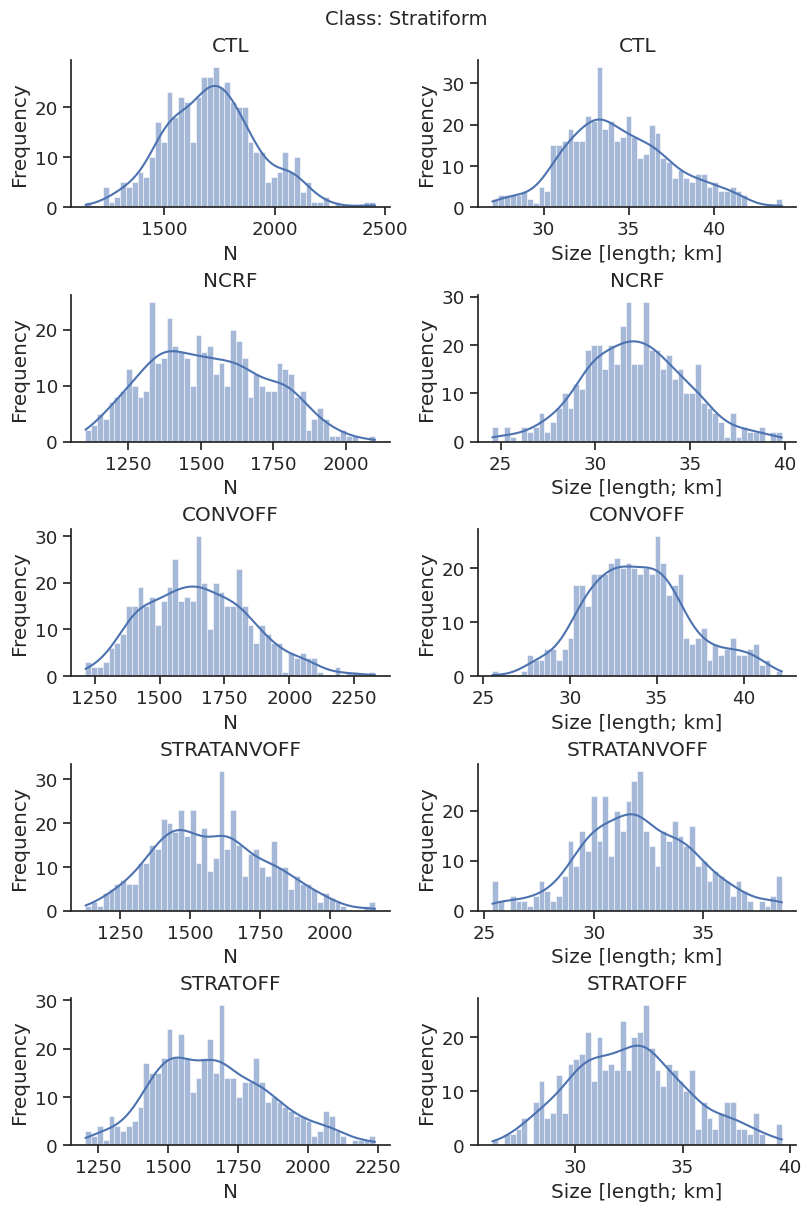

In [33]:
def add_var(figdata, ax):
    ax.set_title(figdata['testtag'])
    ax.set_ylabel('Frequency')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True)

fig_x = 8
fig_y = 12
fig, axs = plt.subplots(5, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

kpclass=4

delta_x2 = 3*3 # km^2, area of each grid cell

# Add title
fig.suptitle('Class: '+pclass_names[kpclass], fontsize=14)

for itest in range(ntest):

    figdata = {
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'N',
        'bins': 50,
        }

    add_var(figdata, axs[itest,0])

    figdata = {
        'pltvar': np.sqrt(mean_size[itest,:,kpclass,:].flatten()*delta_x2), # dims = (ntest, nmem, npclass, nt)
        'testtag': tests_str[itest],
        'units': 'Size [length; km]',
        'bins': 50,
        }

    add_var(figdata, axs[itest,1])
    # add_var(figdata, axs[0,1])

plt.show()
plt.close()

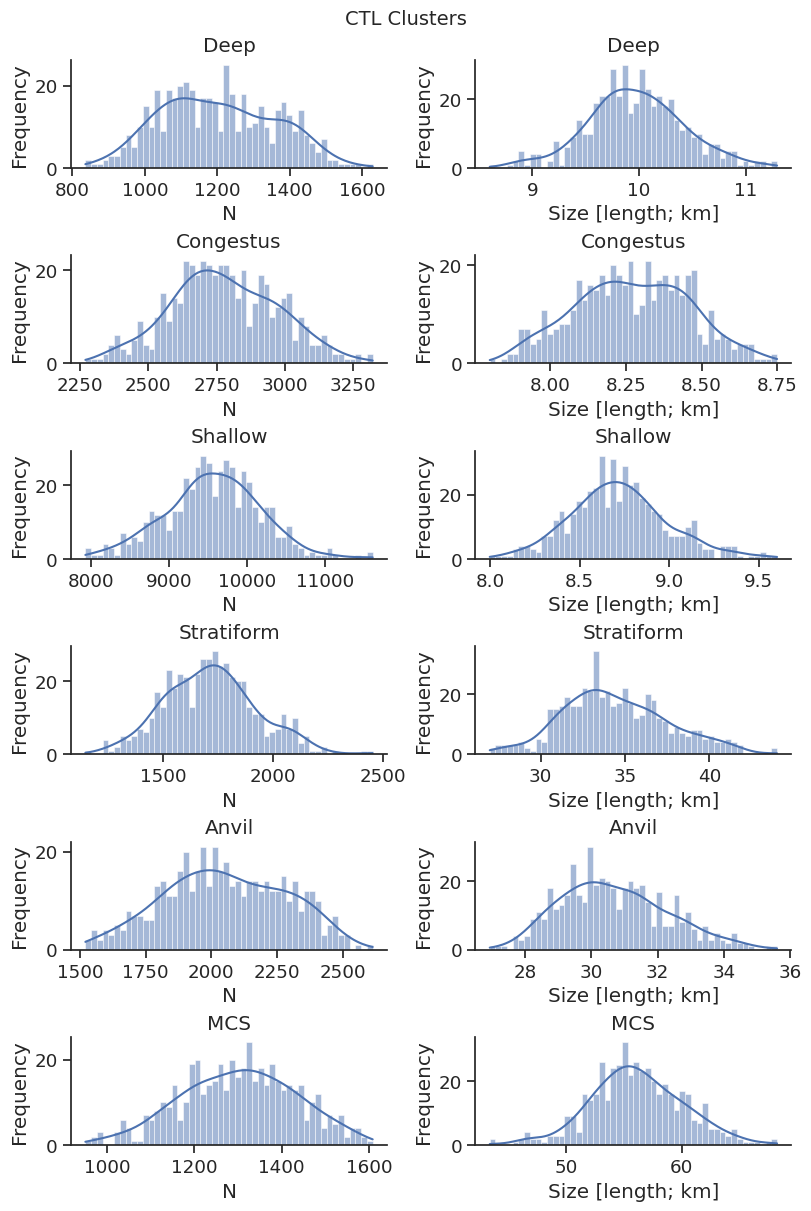

In [35]:
def add_var(figdata, ax):
    ax.set_title(figdata['pclass_str'])
    ax.set_ylabel('Frequency')
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True)

fig_x = 8
fig_y = 12
fig, axs = plt.subplots(6, 2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

# Add title
plt.suptitle('CTL Clusters', fontsize=14)

itest=0

for kpclass in range(1,npclass):

    figdata = {
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'N',
        'bins': 50,
        }

    add_var(figdata, axs[kpclass-1,0])

    figdata = {
        # 'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pltvar': np.sqrt(mean_size[itest,:,kpclass,:].flatten()*delta_x2), # dims = (ntest, nmem, 
        'pclass_str': pclass_names[kpclass],
        'units': 'Size [length; km]',
        'bins': 50,
        }

    add_var(figdata, axs[kpclass-1,1])
    # add_var(figdata, axs[0,1])

plt.show()
plt.close()

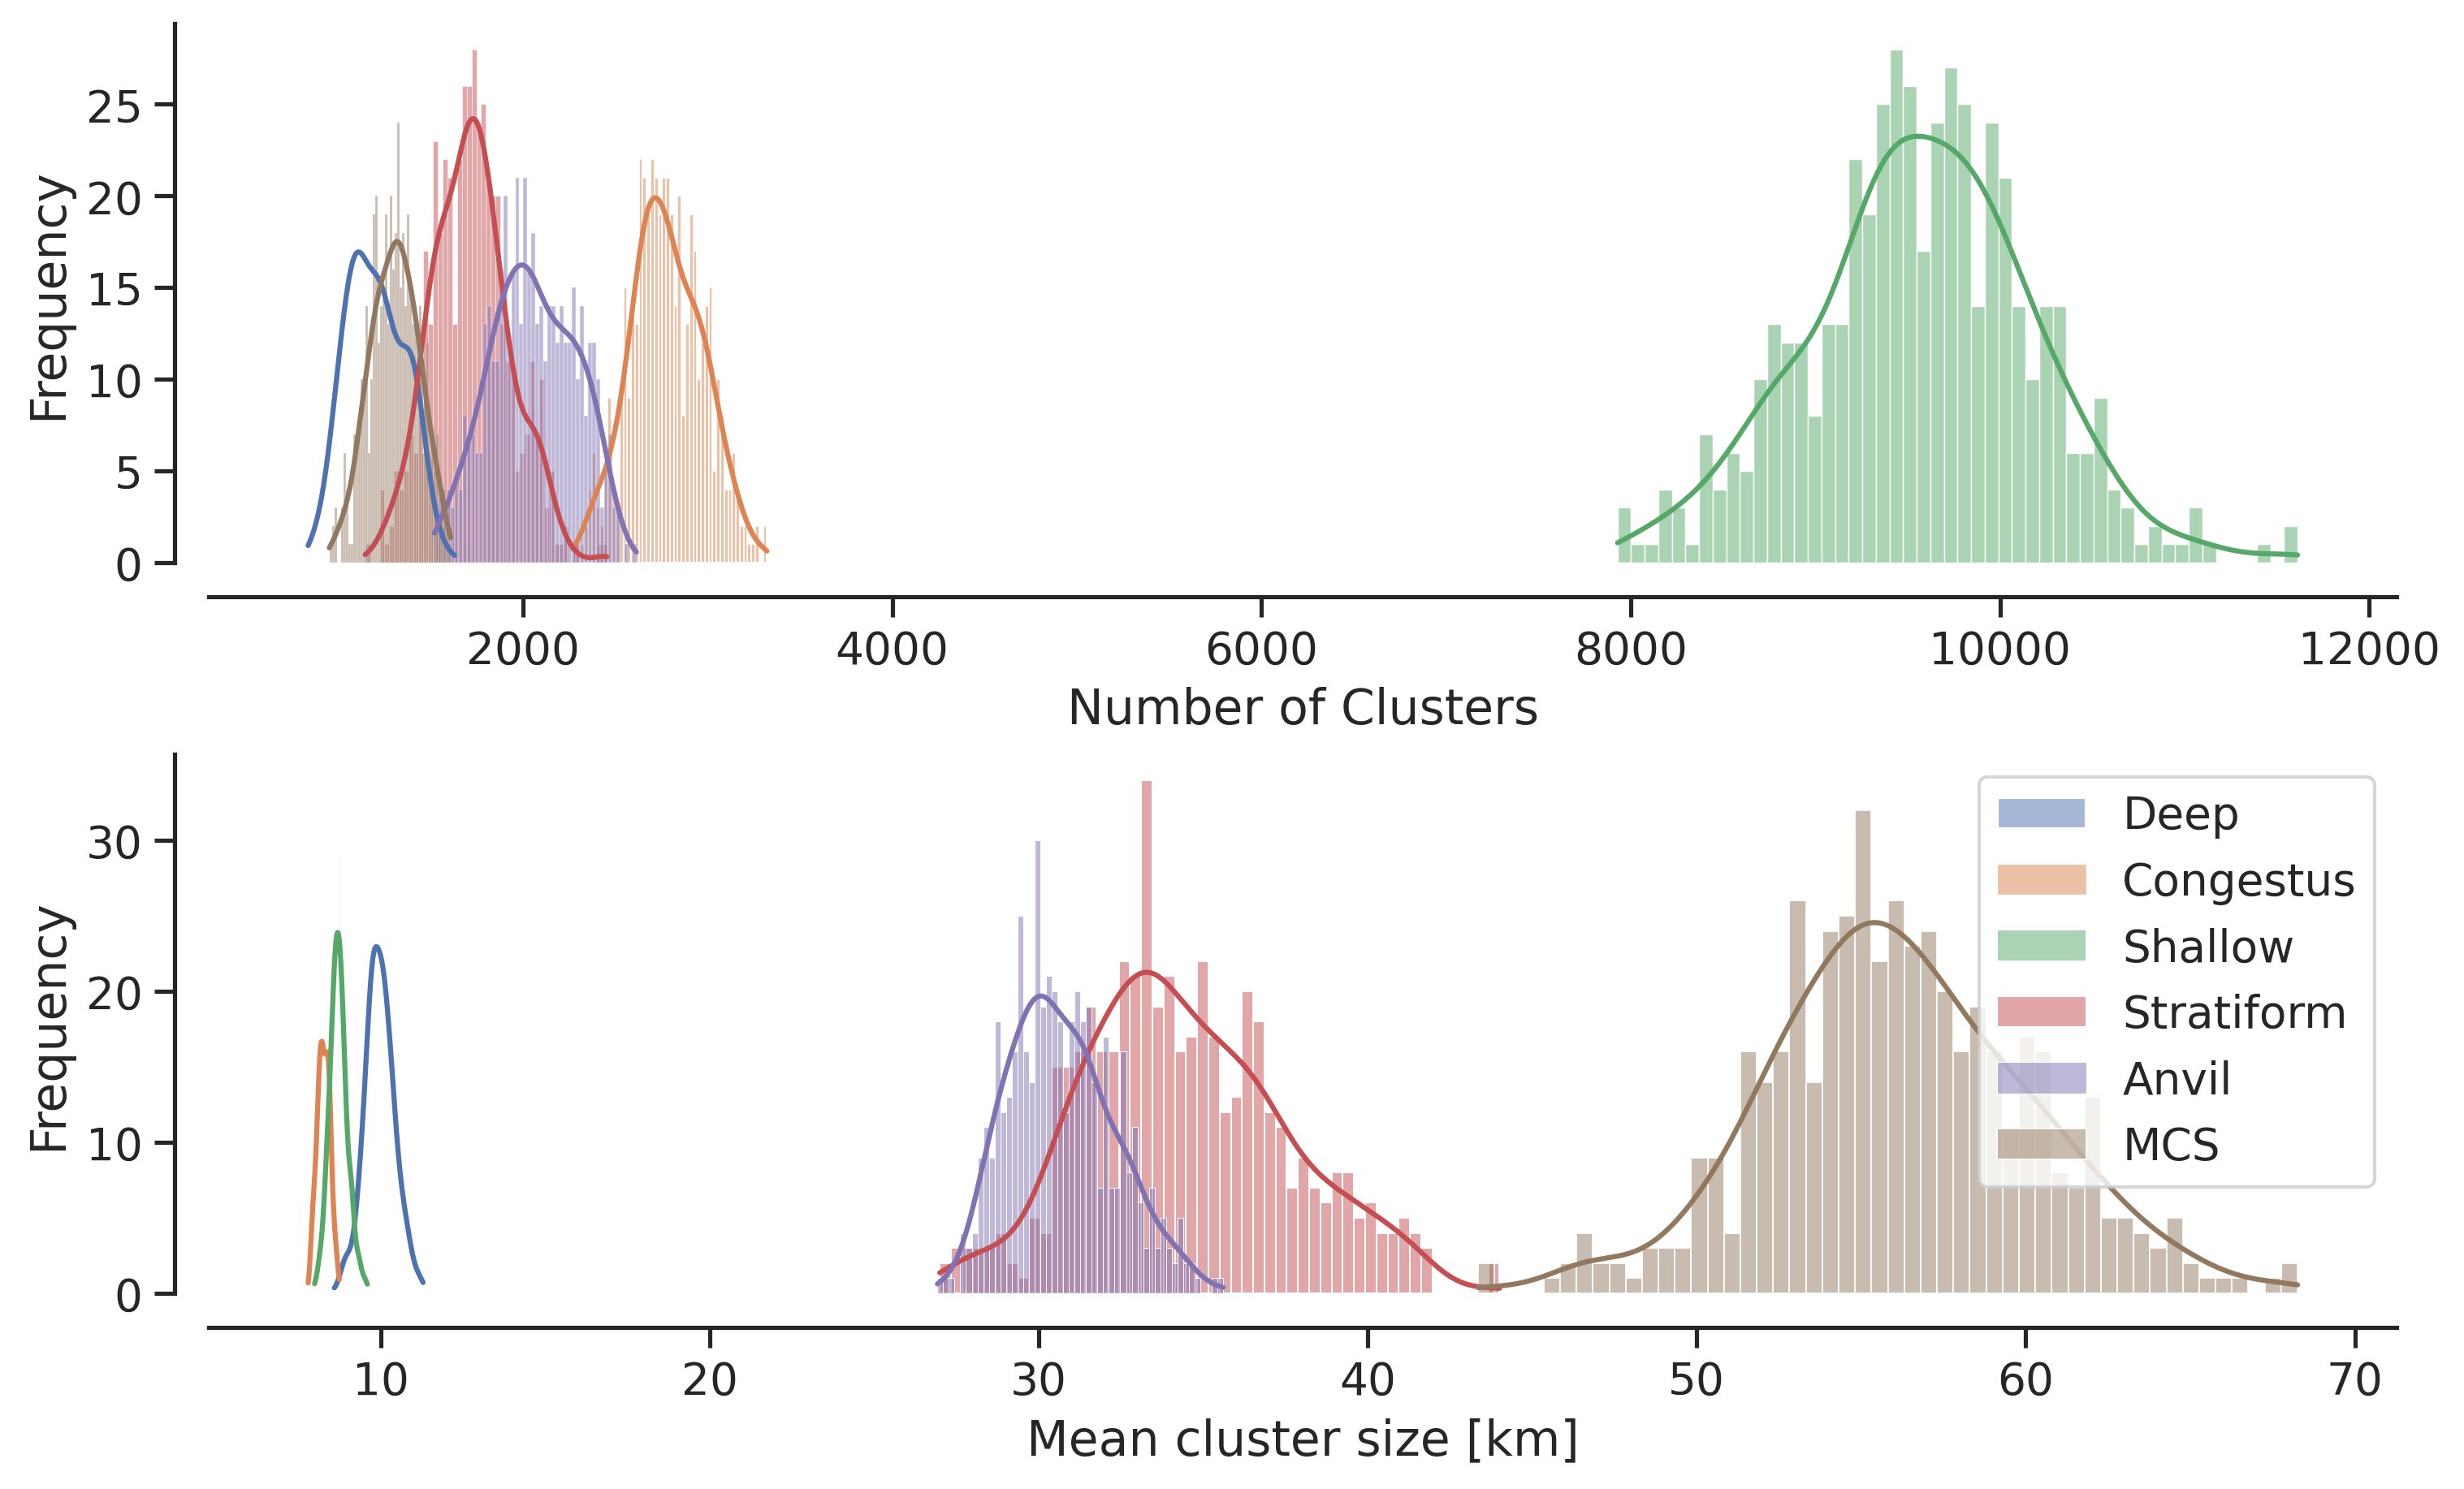

In [37]:
def add_var(figdata, ax):
    ax.set_ylabel('Frequency')
    ax.set_title(figdata['subtitle'])
    ax.set_xlabel(figdata['units'])
    sns.histplot(figdata['pltvar'], ax=ax, kde=True, bins=figdata['bins'], legend=True, label=figdata['pclass_str'])

fig_x = 10
fig_y = 6
fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True, dpi=300)
# fig, axs = plt.subplots(layout='constrained', squeeze=True)

itest=0
# itest=[0,1,2,3,4]

for kpclass in range(1,npclass):
    # if kpclass == 2 or kpclass == 3:
    #     continue

    figdata = {
        # 'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pltvar': number[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'subtitle': '',
        'units': 'Number of Clusters',
        'bins': 50,
        }

    add_var(figdata, axs[0])

    # diam=np.sqrt(3**2 + 3**2)
    # Assume circular geometry
    # area = mean_size
    # area = pi*r^2
    # r = np.sqrt(area/pi)
    # radius = np.sqrt((mean_size*delta_x2)/np.pi)
    # Use area of a square grid cell instead = 3km x 3km = 9 km^2
    sizes = np.sqrt(mean_size*delta_x2)

    figdata = {
        # 'pltvar': mean_size[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        # 'pltvar': mean_size[itest,:,kpclass,:].flatten()*diam, # dims = (ntest, nmem, npclass, nt)
        'pltvar': sizes[itest,:,kpclass,:].flatten(), # dims = (ntest, nmem, npclass, nt)
        'pclass_str': pclass_names[kpclass],
        'units': 'Mean cluster size [km]',
        'subtitle': '',
        'bins': 50,
        }

    add_var(figdata, axs[1])
    # add_var(figdata, axs[0,1])

sns.despine(ax=axs[0], offset=10)
sns.despine(ax=axs[1], offset=10)
# axs[0].set_title('Number')
# axs[1].set_title('Mean Size')
# plt.suptitle('Cluster Analysis')

plt.legend()
plt.show()
plt.close()

#### KDE or Box Plots

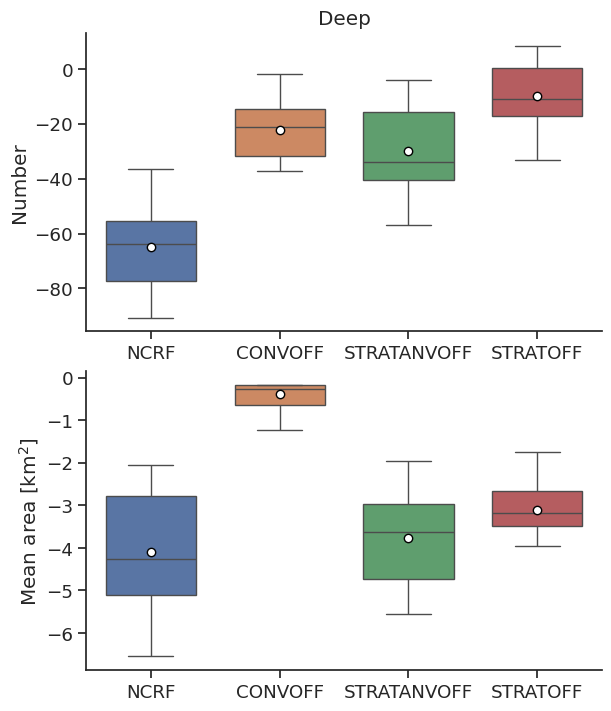

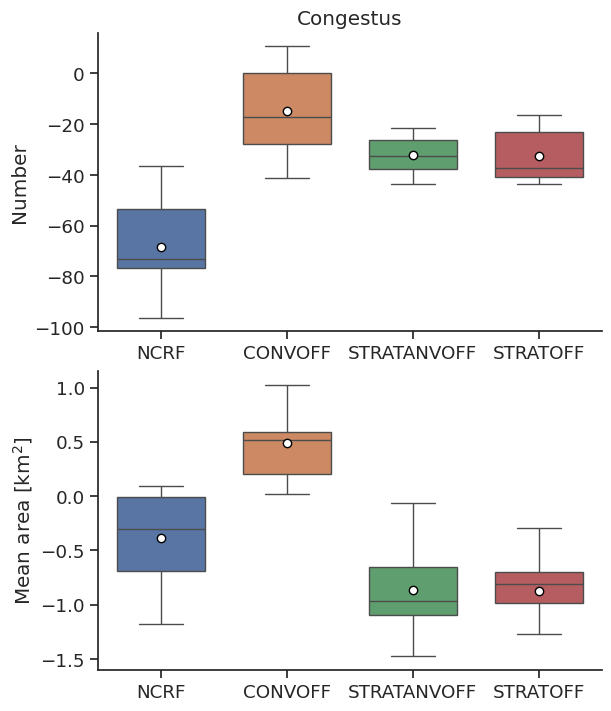

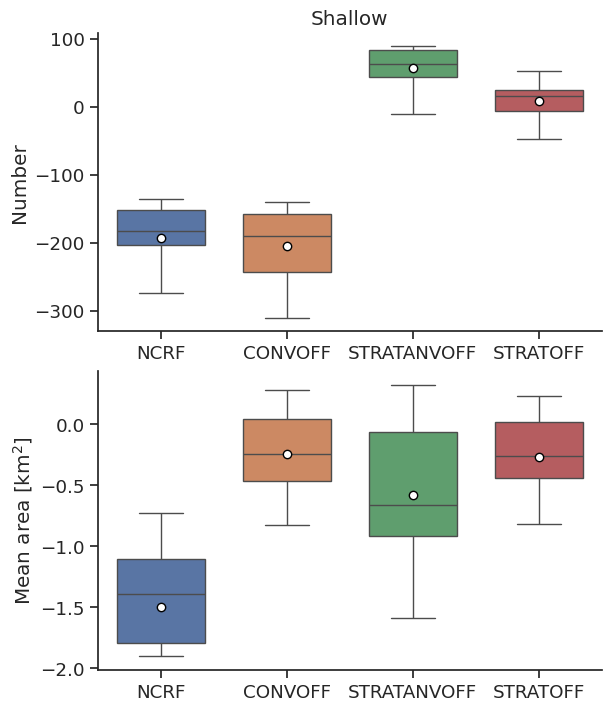

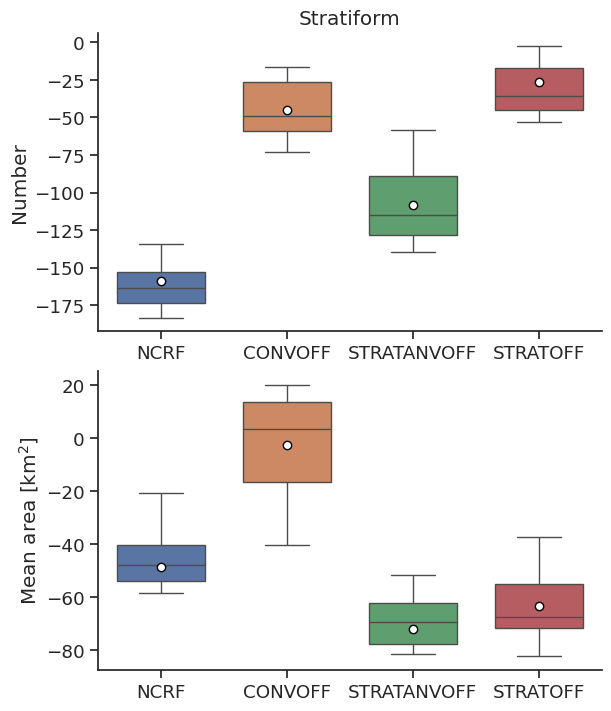

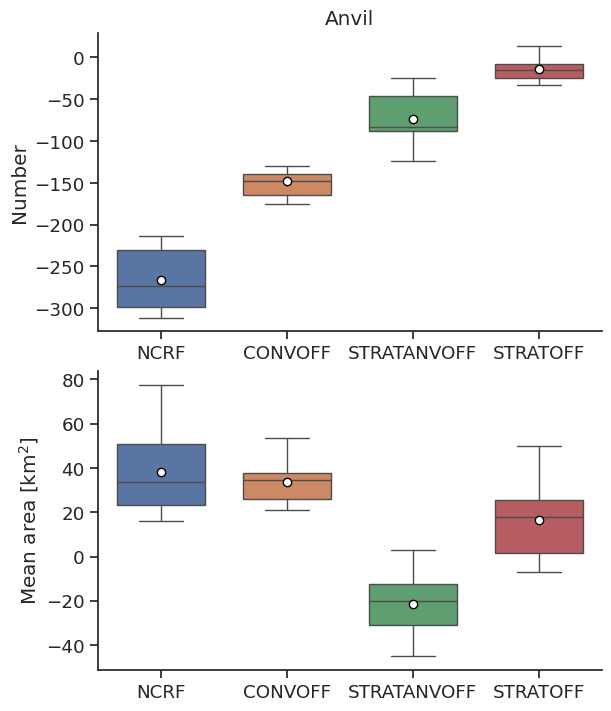

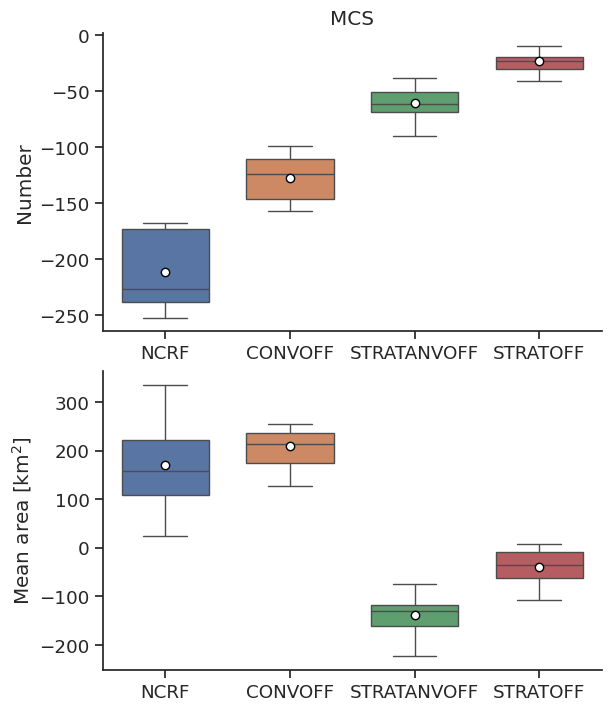

In [38]:
def do_kdeplot(figdata):
    ntest = figdata['number'].shape[0]
    nmem = figdata['number'].shape[1]
    fig_x, fig_y = 6, 7
    fig, ax = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    ax[0].set_title(figdata['title'])
    ax[0].set_ylabel(figdata['units1'])
    ax[1].set_ylabel(figdata['units2'])
    df = pd.DataFrame(data=np.reshape(figdata['number'], (ntest, nmem)).transpose(), columns=figdata['tests_str'])
    sns.boxplot(df,
                ax=ax[0], width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})
    df = pd.DataFrame(data=np.reshape(figdata['size'], (ntest, nmem)).transpose(), columns=figdata['tests_str'])
    sns.boxplot(df,
                ax=ax[1], width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})
    plt.show()
    plt.close()

area_grid_cell = 9 # km**2

# t_ind=np.arange(t1_test)
t_ind=np.arange(24)
# t_ind=np.arange(42,48)
mean_size_mn = np.mean(mean_size[:,:,:,t_ind], axis=3)*area_grid_cell # km**2
number_mn = np.mean(number[:,:,:,t_ind], axis=3)

diam_mn = 2*np.sqrt((mean_size_mn*area_grid_cell)/np.pi)

# As difference from CTL
number_ctlanom = number_mn - number_mn[0,:,:]
diam_ctlanom = diam_mn - diam_mn[0,:,:]
mean_size_ctlanom = mean_size_mn - mean_size_mn[0,:,:]

for kpclass in range(1,npclass):

    figdata = {
        # 'size': diam_mn[:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        # 'number': number_mn[:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        # 'size': mean_size_mn[:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        # 'tests_str': tests_str,
        'number': number_ctlanom[1:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        'size': diam_ctlanom[1:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        'size': mean_size_ctlanom[1:,:,kpclass], # dims = (ntest, nmem, npclass, nt)
        'tests_str': tests_str[1:],
        'title': pclass_names[kpclass],
        'units1': 'Number',
        # 'units2': 'Mean size [km]',
        'units2': 'Mean area [km$^2$]',
        }

    do_kdeplot(figdata)

#### Time series

In [39]:
def do_smooth(invar, nt_smooth=5):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar.transpose())
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm1).transpose())

In [40]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    conf_set=0.95 # Confidence interval to apply throughout
    # conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [41]:
def do_tser(figdata, do_legend=False):
    ntest = figdata['number'].shape[0]
    smooth=True
    # smooth=False
    fig_x, fig_y = 6, 6
    fig, ax = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    ax[0].set_title(figdata['units'])
    # ax[0].set_title('Mean Diamater [km]')
    # ax[1].set_title('Number [km]')
    ax[0].set_ylabel('Number')
    # ax[1].set_ylabel('Mean radius [km]')
    ax[1].set_ylabel('Mean area [km$^2$]')
    # ax[0].set_xlabel('Time [hour]')
    ax[1].set_xlabel('Time [hour]')
    linecolor=['black', 'red', 'blue', 'green', 'green']
    # linecolor=['red', 'blue', 'green', 'green']
    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linestyle[-1]='dashed'
    for iax in range(2):
        if iax == 0:
            pltvar = figdata['number']
        else:
            pltvar = figdata['size']
        for itest in range(ntest):
            pvar = pltvar[itest]
            if smooth:
                pvar = do_smooth(pvar)
            mean, low, high = mean_confidence_interval(pvar)
            ax[iax].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # var_smooth = pd.DataFrame(mean)
            # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
            # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            if (itest == 0) or (itest == 1):
                xdim = range(0,mean.shape[0])
                ax[iax].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
    if do_legend:
        plt.legend(loc='upper left', prop={'size': 10})
    plt.show()
    plt.close()

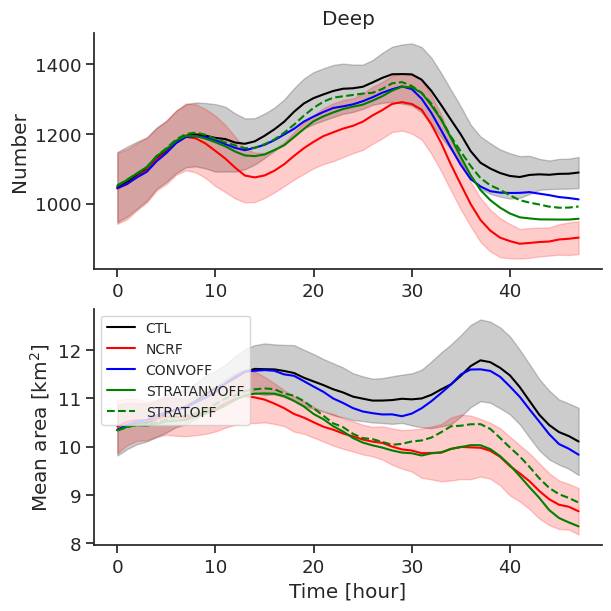

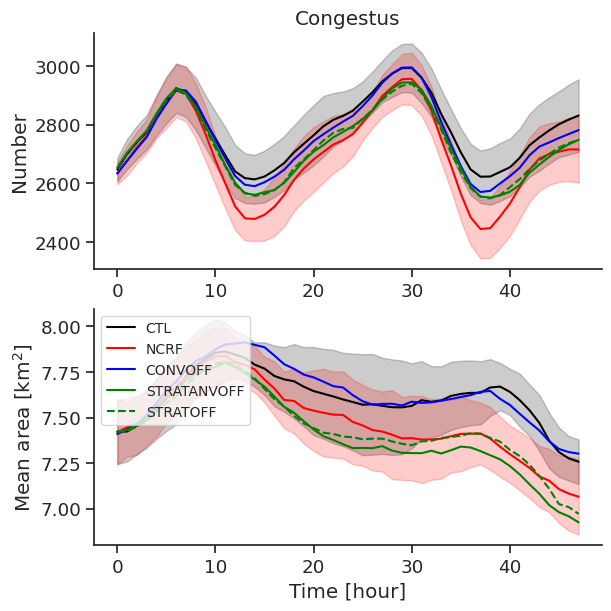

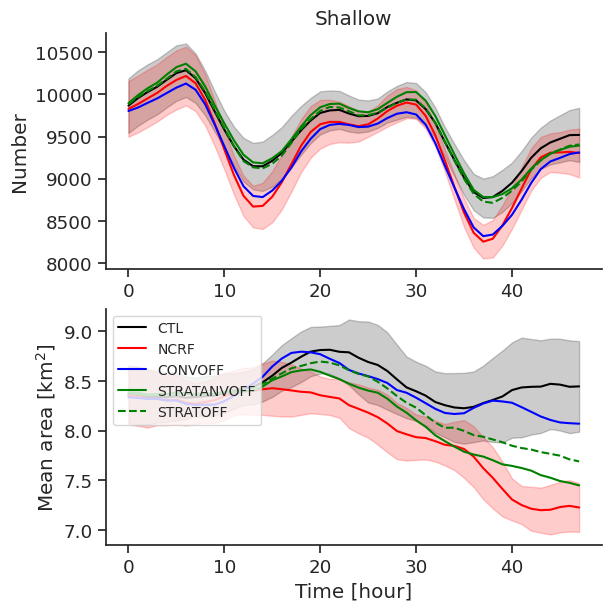

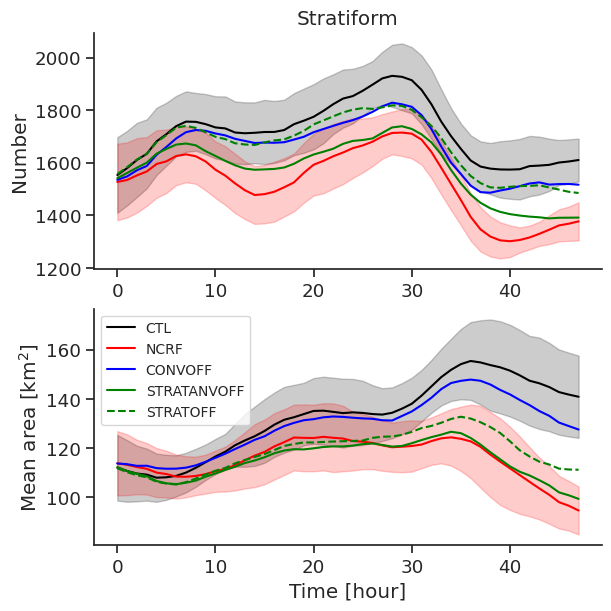

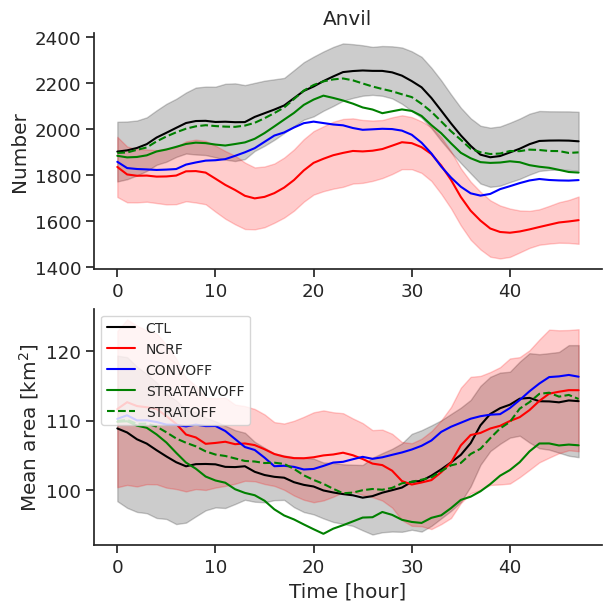

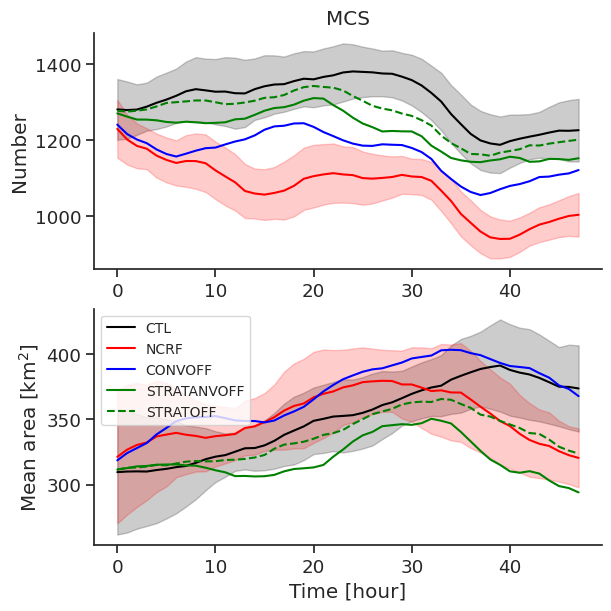

In [42]:
area_grid_cell = 9 # km**2
radius = np.sqrt((mean_size*area_grid_cell)/np.pi)

# As difference from CTL
number_ctlanom = number - number[0,...]
diam_ctlanom = radius - radius[0,...]
mean_size_ctlanom = mean_size - mean_size[0,...]

for kpclass in range(1,npclass):

    figdata = {
        'size': radius[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        'number': number[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        'size': mean_size[:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        # 'number': number_ctlanom[1:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        # 'size': mean_size_ctlanom[1:,:,kpclass,:], # dims = (ntest, nmem, npclass, nt)
        # 'testtag': tests_str[1:itest],
        'units': pclass_names[kpclass],
        }

    # do_legend=False
    # if kpclass == npclass-1:
    do_legend=True

    do_tser(figdata, do_legend=do_legend)

In [59]:
def do_tser(figdata, do_legend=False):
    ntest = figdata['number'].shape[0]
    smooth=True
    # smooth=False
    pclass_plot = [1,4,5,6]
    npclass_plot = len(pclass_plot)
    fig_x, fig_y = 10, 12
    fig, ax = plt.subplots(npclass_plot,2, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)
    ax[npclass_plot-1,0].set_xlabel('Time [hour]')
    ax[npclass_plot-1,1].set_xlabel('Time [hour]')
    t_max = t1_test
    # linecolor=['black', 'red', 'blue', 'green', 'green']
    # linecolor=['black', 'blue', 'red', 'green', 'green']
    linecolor=['blue', 'red', 'green', 'green']
    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linestyle[-1]='dashed'
    for ipclass in range(npclass_plot):
        for icol in range(2):
            if icol == 0:
                pltvar = figdata['number']
                ax[0,icol].set_title('Number')
            else:
                pltvar = figdata['size']
                # ax[0,icol].set_title('Mean Diamater [km]')
                ax[0,icol].set_title('Mean size [length; km]')
            # Plot zero line
            ax[ipclass,icol].axhline(0, color='black', linewidth=1)
            pltvar = pltvar[:,:,pclass_plot[ipclass],:]
            ax[ipclass,icol].set_ylabel(figdata['units'][pclass_plot[ipclass]])
            ax[ipclass,icol].set_xlim([0,t_max])
            for itest in range(ntest):
                pvar = pltvar[itest]
                if smooth:
                    pvar = do_smooth(pvar)
                mean, low, high = mean_confidence_interval(pvar)
                ax[ipclass,icol].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=figdata['tests_str'][itest])
                # var_smooth = pd.DataFrame(mean)
                # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
                # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
                # if (itest == 0) or (itest == 2):
                if (itest == 1) or (itest == 2):
                    xdim = range(0,mean.shape[0])
                    ax[ipclass,icol].fill_between(xdim, high, low, alpha=0.1, color=linecolor[itest])
    if do_legend:
        plt.legend(prop={'size': 10})#, loc='upper left')
    plt.show()
    plt.close()

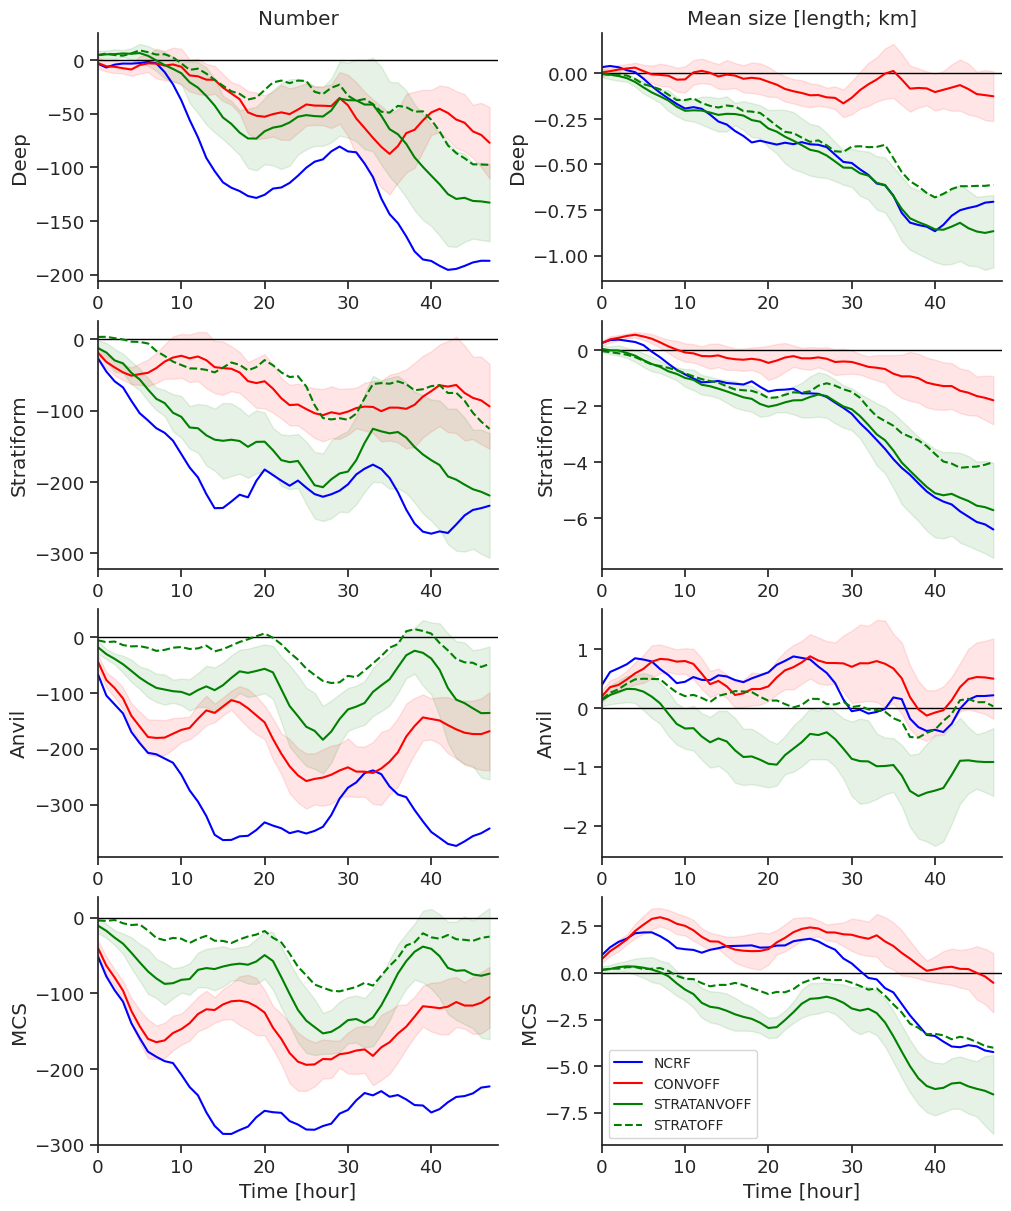

In [60]:
# area_grid_cell = 9 # km**2
# diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)
sizes_sqrt = np.sqrt(mean_size*delta_x2)

def ctldiff(invar):
    return invar - invar[0,...]
    # ctl_ensmean = np.mean(invar[0,...], axis=0)
    # return invar - ctl_ensmean[np.newaxis,np.newaxis,...]

# Difference from CTL
number_ctlanom = ctldiff(number)
# radius_ctlanom = ctldiff(radius)
# mean_size_ctlanom = ctldiff(mean_size)
mean_size_ctlanom = ctldiff(sizes_sqrt)

figdata = {
    # 'size': diam, # dims = (ntest, nmem, npclass, nt)
    # 'size': mean_size, # dims = (ntest, nmem, npclass, nt)
    # 'number': number, # dims = (ntest, nmem, npclass, nt)
    'size': mean_size_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
    'number': number_ctlanom[1:], # dims = (ntest, nmem, npclass, nt)
    'tests_str': tests_str[1:],
    'units': pclass_names,
    }

do_legend=True
# if kpclass == npclass-1:
#     do_legend=True

do_tser(figdata, do_legend=do_legend)

#### Check N*size ~~ area

In [45]:
# def do_kdeplot(figdata):
#     fig, ax = plt.subplots(layout='constrained', squeeze=True)
#     ax.set_title(figdata['units'])
#     ax.set_ylabel('Count')
#     # ax.set_xlabel(figdata['units'])
#     print(figdata['pltvar'].shape)
#     ntnew=figdata['pltvar'].shape[2]
#     print(npclass,nmem, ntnew)
#     df = pd.DataFrame(data=np.reshape(figdata['pltvar'], (npclass-1, nmem*ntnew)).transpose(), columns=pclass_names[1:])
#     # sns.kdeplot(df, ax=ax, legend=True)
#     sns.boxplot(df,
#                 width=0.7, showmeans=True, showfliers=False,
#                 meanprops={"marker":"o", "markerfacecolor":"white", 
#                 "markeredgecolor":"black", "markersize":"6"})

# # t_ind=range(t1_test)
# # t_ind=range(6)

# mean_size_ts = np.transpose(mean_size, axes=(2,0,1,3))
# number_ts = np.transpose(number, axes=(2,0,1,3))

# # for kpclass in range(1,npclass):
# itest=0
# figdata = {
#     # 'pltvar': mean_size[itest,:,kpclass,t_ind]*number[itest,:,kpclass,t_ind]/(ntest*nmem*6), # dims = (ntest, nmem, npclass, nt)
#     'pltvar': mean_size_ts[1:,itest,:,0:6]*number_ts[1:,itest,:,0:6], # dims = (ntest, nmem, npclass, nt)
#     'units': 'N*Size',
#     }

# do_kdeplot(figdata)

#### Box plots of full cluster size distribution

In [46]:
# # Function to get full distribution of cluster sizes

# def get_cluster_sizes(nt_read):

#     dims = (npclass, ntest, nmem)
#     number = np.zeros(dims)

#     cluster_size_allclass=[]
#     for kpclass in range(npclass):

#         cluster_size_alltest=[]
#         for itest in range(ntest):
#             # Loop over ensemble members
#             for imemb in range(nmem):

#                 pickle_file1 = main_pickle+memb_all[imemb]+'/pclass_'+tests[itest]+'_48hrs.pkl'
#                 with open(pickle_file1, 'rb') as file:
#                     pclass, ipclass_area = pickle.load(file)

#                 for it in range(nt_read):
#                     labeled_matrix, num_features = label(pclass[it,...] == kpclass)
#                     icluster_size = ndi_sum(pclass[it,...], labeled_matrix, index=np.arange(1, num_features + 1))
#                     number[kpclass, itest, imemb] += num_features
#                     if it == 0:
#                         cluster_size = np.copy(icluster_size)
#                     else:
#                         cluster_size = np.concatenate((cluster_size, icluster_size))

#                 if imemb == 0:
#                     cluster_size_allmemb = np.copy(cluster_size)
#                 else:
#                     cluster_size_allmemb = np.concatenate((cluster_size_allmemb, cluster_size))

#             cluster_size_alltest.append(cluster_size_allmemb)
#         cluster_size_allclass.append(cluster_size_alltest)

#     return cluster_size_allclass, number

In [47]:
# # Plot function
# def do_cluster_plot(figdata):
#     fig, ax = plt.subplots(layout='constrained', squeeze=True)
#     ax.set_title(figdata['units'])
#     ax.set_ylabel('Count')
#     # df = pd.DataFrame(data=figdata['pltvar'], index=tests_str)
#     pltvar_dict = {tests_str[itest]: figdata['pltvar'][itest] for itest in range(ntest)}
#     sns.boxplot(pltvar_dict,
#                 width=0.7, showmeans=True, showfliers=False,
#                 meanprops={"marker":"o", "markerfacecolor":"white", 
#                 "markeredgecolor":"black", "markersize":"6"},
#                 )

# # Sampling window
# nt_read = 6

# cluster_size, number = get_cluster_sizes(nt_read)

# for kpclass in range(1,npclass):
# # kpclass=1
#     figdata = {
#         'pltvar': cluster_size[kpclass], # npclass, ntest, n-flattened-clusters
#         'units': 'Cluster Size: '+pclass_names[kpclass],
#         }
#     do_cluster_plot(figdata)